<a href="https://colab.research.google.com/github/nsp8/Machine-Learning-Resources/blob/colab-ml-practice/regression_flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from google.colab import drive


In [13]:
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


In [3]:
base_folder_path = os.path.join('/gdrive', 'My Drive', 'Projects', 'ML Practice', 'Regression: flood prediction', 'data')
print(os.path.exists(base_folder_path))

True


In [4]:
train_data = pd.read_csv(os.path.join(base_folder_path, "train.csv"))
train_data.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [5]:
train_data.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

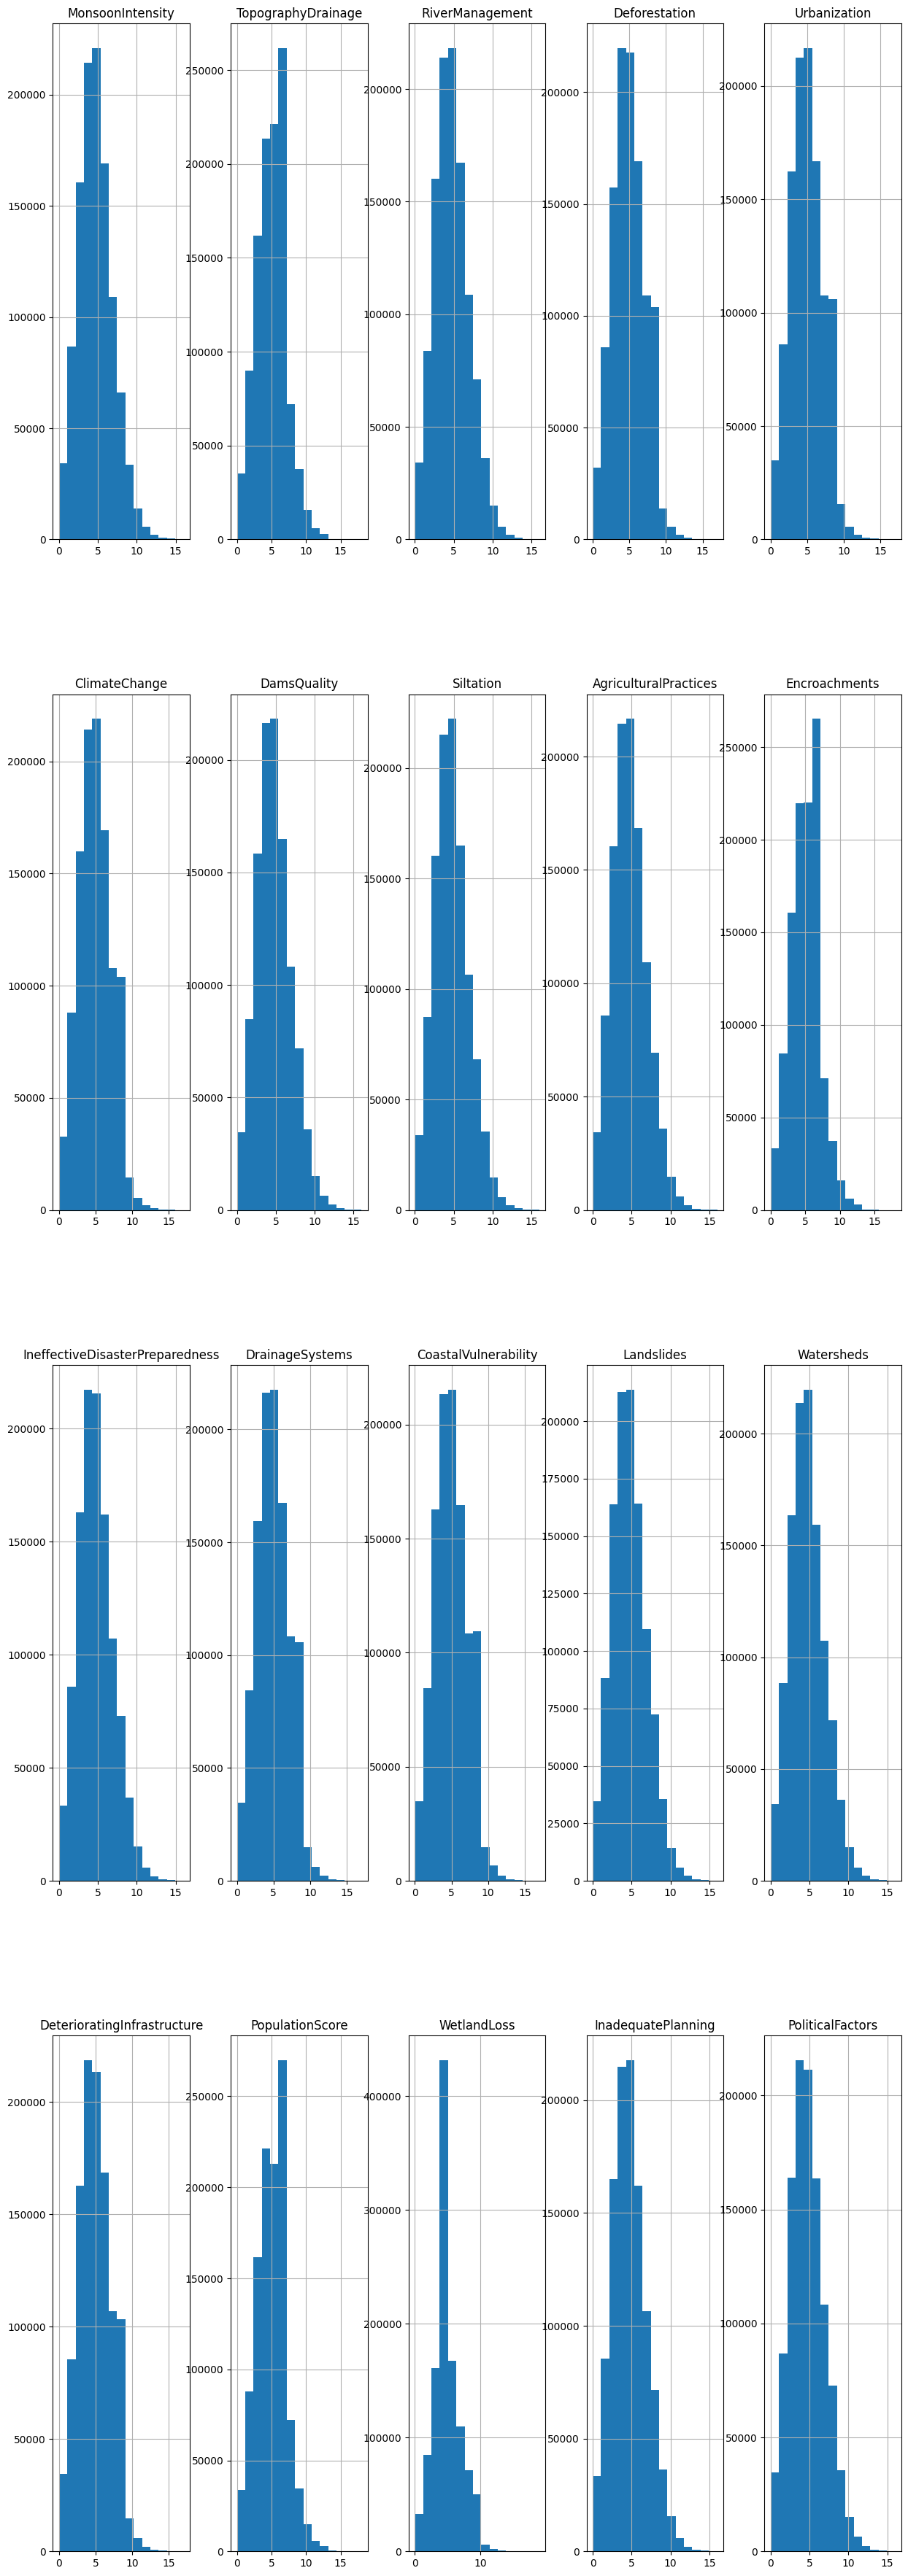

In [20]:
features_train = train_data.set_index("id")
label_train = features_train.pop("FloodProbability")
features_train.hist(bins=15, figsize=(15, 45), layout=(4, 5))

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

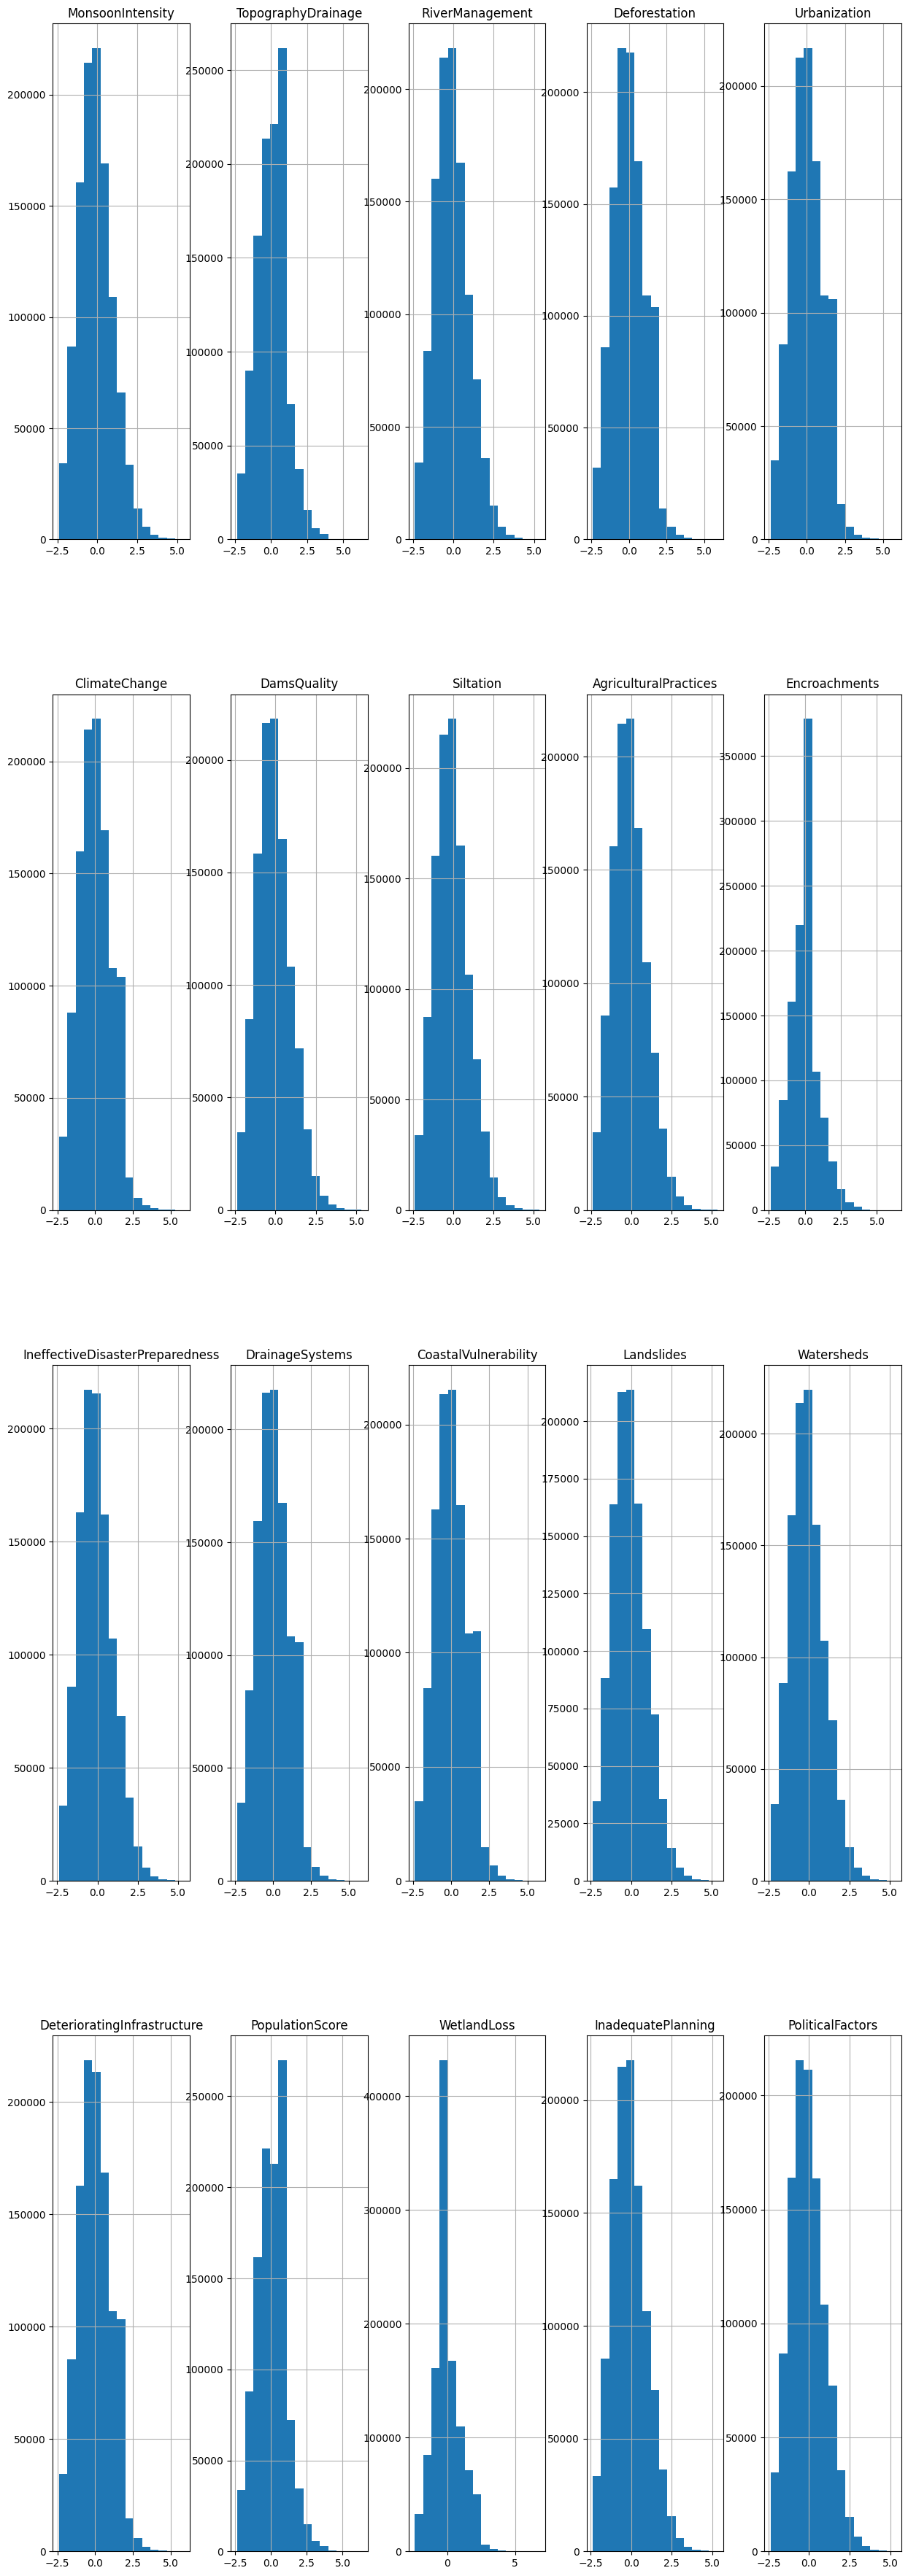

In [22]:
def standardize(data):
    standard_scaler = StandardScaler()
    standard_scaler.fit(data)
    return standard_scaler.transform(data)
    # _data = data.copy(deep=True)
    # return (_data - _data.mean(axis=0)) / _data.std(axis=0)


features_train_standardized = standardize(features_train)
# features_train_standardized.hist(bins=15, figsize=(15, 45), layout=(4, 5))
